In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import glob
import sys
import pandasql as pdsql
import importlib
from brokenaxes import brokenaxes

sys.path.append("..")
import analysislib as alib
importlib.reload(alib)

# ABOVE ZNONEOFTHE

sq = lambda q: pdsql.sqldf(q, globals())
sqflat = lambda q: alib.flatten(pdsql.sqldf(q, globals()).values.tolist())

plt.rcParams.update({'font.size': 14, 'legend.fontsize': 12})

# O1 - compressibility

In [16]:
df = pd.read_csv("../../data-raven3/2025-10-05-time-18-05-24-compressibile-question-mark/master.csv")

In [17]:
sq("SELECT * FROM df LIMIT 5")

,Unnamed: 0,cbSize,cioengine,ciodepth,crw,cnproc,cdevice,cdirect,cmemlim,cfile,...,diskutil-TOTAL_WRITES(KB),diskutil-TOTAL_READS(MB),diskutil-TOTAL_WRITES(MB),diskutil-TOTAL_READS(GB),diskutil-TOTAL_WRITES(GB),diskutil-rMB/s,diskutil-wMB/s,diskutil-AVGRQ-SZ,diskutil-AVGQU-SZ,diskutil-DEV_UTIL
0,0,65536,sync,1,read,1,ssd,1,none,none,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,65536,sync,1,read,1,zram-lzo,1,none,none,...,4194632.0,4096.0,4096.0,4.0,4.0,1.01500,684.427,2.23333,0.241667,23.1250
2,2,65536,sync,1,read,1,zram-zstd,1,none,none,...,4194656.0,4096.0,4096.0,4.0,4.0,167.54100,256.707,4.85062,0.691875,68.8094
3,3,65536,sync,1,read,1,zram-lz4,1,none,none,...,4194920.0,4096.0,4096.0,4.0,4.0,1.01833,684.408,2.22833,0.271667,26.2967
4,4,65536,sync,1,read,1,ssd,1,none,none,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.columns

Index(['Unnamed: 0', 'cbSize', 'cioengine', 'ciodepth', 'crw', 'cnproc',
       'cdevice', 'cdirect', 'cmemlim', 'cfile', 'cbuffer_compress_percentage',
       'cbuffer_compress_chunk', 'readBW_bytes', 'readBW', 'writeBW_bytes',
       'writeBW', 'avgreadlat_ns', 'avgreadlat', 'avgwritelat_ns',
       'avgwritelat', 'USR_UTIL_perc', 'SYS_UTIL_perc', 'IOW_UTIL_perc',
       'IDL_UTIL_perc', 'CPU_UTIL_perc', 'diskutil-TOTAL_READS(KB)',
       'diskutil-TOTAL_WRITES(KB)', 'diskutil-TOTAL_READS(MB)',
       'diskutil-TOTAL_WRITES(MB)', 'diskutil-TOTAL_READS(GB)',
       'diskutil-TOTAL_WRITES(GB)', 'diskutil-rMB/s', 'diskutil-wMB/s',
       'diskutil-AVGRQ-SZ', 'diskutil-AVGQU-SZ', 'diskutil-DEV_UTIL'],
      dtype='object')

In [19]:
sq("""SELECT cdevice, cbuffer_compress_percentage, readBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df
              WHERE crw='read' AND cdevice='zram-lzo'
              ORDER BY cdevice, cbuffer_compress_percentage"""), 

(     cdevice  cbuffer_compress_percentage  readBW_GB
 0   zram-lzo                            0   7.504690
 1   zram-lzo                           10   7.326007
 2   zram-lzo                           20   4.237288
 3   zram-lzo                           30   3.524229
 4   zram-lzo                           40   3.358522
 5   zram-lzo                           50   3.122560
 6   zram-lzo                           60   2.844950
 7   zram-lzo                           70   5.420054
 8   zram-lzo                           80   5.340454
 9   zram-lzo                           90   4.102564
 10  zram-lzo                          100  12.232416,)

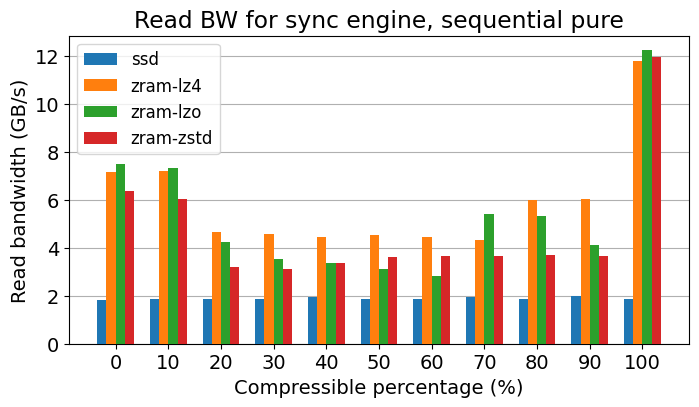

In [20]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cbuffer_compress_percentage FROM df ORDER BY cbuffer_compress_percentage"), 
    sqflat("""SELECT readBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df
              WHERE crw='read'
              ORDER BY cdevice, cbuffer_compress_percentage"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df ORDER BY cdevice"),
    xlabel="Compressible percentage (%)",
    ylabel="Read bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O1-readBW.png", bbox_inches="tight")
plt.title("Read BW for sync engine, sequential pure")
plt.show()

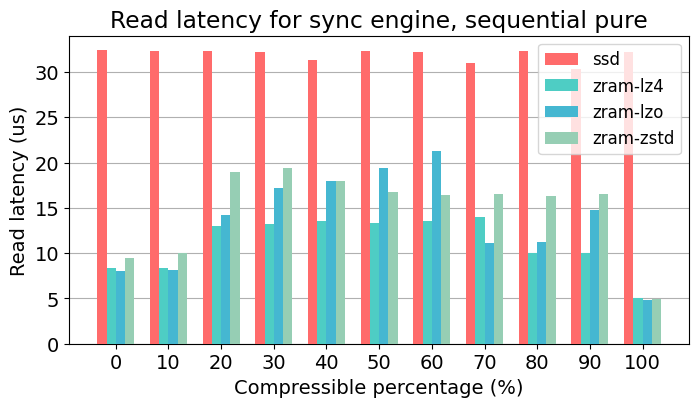

In [21]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cbuffer_compress_percentage FROM df ORDER BY cbuffer_compress_percentage"), 
    sqflat("""SELECT avgreadlat_ns/(1000.0) AS readlat_us
              FROM df
              WHERE crw='read'
              ORDER BY cdevice, cbuffer_compress_percentage"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df ORDER BY cdevice"),
    colors=["#ff6b6b", "#4ecdc4", "#45b7d1", "#96ceb4"],
    xlabel="Compressible percentage (%)",
    ylabel="Read latency (us)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O1-readlat.png", bbox_inches="tight")
plt.title("Read latency for sync engine, sequential pure")
plt.show()

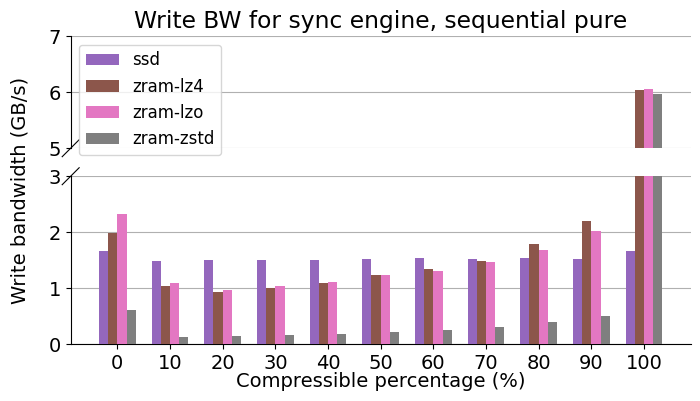

In [22]:
plt.figure(figsize=(8, 4))

bax = brokenaxes(ylims=((0, 3), (5, 7))) 
                 
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cbuffer_compress_percentage FROM df ORDER BY cbuffer_compress_percentage"), 
    sqflat("""SELECT writeBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df
              WHERE crw='write'
              ORDER BY cdevice, cbuffer_compress_percentage"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df ORDER BY cdevice"),
    colors=["#9467bd", "#8c564b", '#e377c2', '#7f7f7f'],
    xlabel="Compressible percentage (%)",
    ylabel="Write bandwidth (GB/s)",
    show=False,
    # create_new_figure=False,
    figsize=[8, 4],
    ax=bax
)

bax.legend(loc="upper left")
bax.set_xlabel("Compressible percentage (%)", labelpad=20)
# bax.set_xticks(sqflat("SELECT DISTINCT cbuffer_compress_percentage FROM df ORDER BY cbuffer_compress_percentage"))
plt.savefig("../../processed-data/2025-10-06-final-run/A-O1-writeBW.png", bbox_inches="tight")
plt.title("Write BW for sync engine, sequential pure")
plt.show()

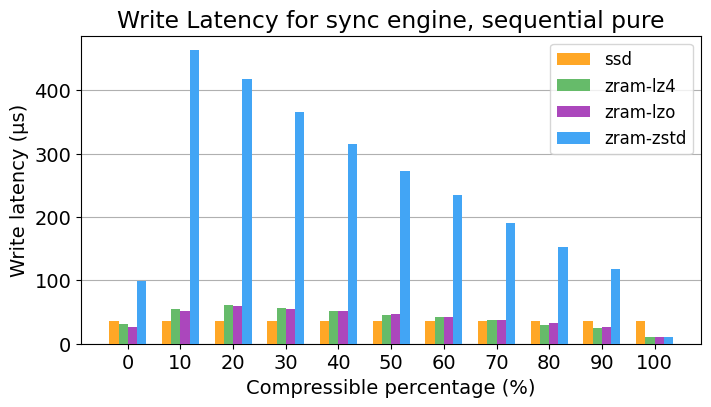

In [23]:
# write latency
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cbuffer_compress_percentage FROM df ORDER BY cbuffer_compress_percentage"), 
    sqflat("""SELECT avgwritelat_ns/(1000.0) AS writelat_us
              FROM df
              WHERE crw='write'
              ORDER BY cdevice, cbuffer_compress_percentage"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df ORDER BY cdevice"),
    colors=["#ffa726", "#66bb6a", "#ab47bc", "#42a5f5"],
    xlabel="Compressible percentage (%)",
    ylabel="Write latency (µs)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O1-writelat.png", bbox_inches="tight")
plt.title("Write Latency for sync engine, sequential pure")
plt.show()

# O2 - async

In [24]:
df2 = pd.read_csv("../../data-raven3/2025-10-05-time-18-59-39-async-perf/master.csv")
df2_write_redo = pd.read_csv("../../data-raven3/2025-10-17-time-13-17-27-ssd-async-redo/master.csv")

In [25]:
df2.columns

Index(['Unnamed: 0', 'cbSize', 'cioengine', 'ciodepth', 'crw', 'cnproc',
       'cdevice', 'cdirect', 'cmemlim', 'cfile', 'cbuffer_compress_percentage',
       'cbuffer_compress_chunk', 'readBW_bytes', 'readBW', 'writeBW_bytes',
       'writeBW', 'avgreadlat_ns', 'avgreadlat', 'avgwritelat_ns',
       'avgwritelat', 'USR_UTIL_perc', 'SYS_UTIL_perc', 'IOW_UTIL_perc',
       'IDL_UTIL_perc', 'CPU_UTIL_perc', 'diskutil-TOTAL_READS(KB)',
       'diskutil-TOTAL_WRITES(KB)', 'diskutil-TOTAL_READS(MB)',
       'diskutil-TOTAL_WRITES(MB)', 'diskutil-TOTAL_READS(GB)',
       'diskutil-TOTAL_WRITES(GB)', 'diskutil-rMB/s', 'diskutil-wMB/s',
       'diskutil-AVGRQ-SZ', 'diskutil-AVGQU-SZ', 'diskutil-DEV_UTIL'],
      dtype='object')

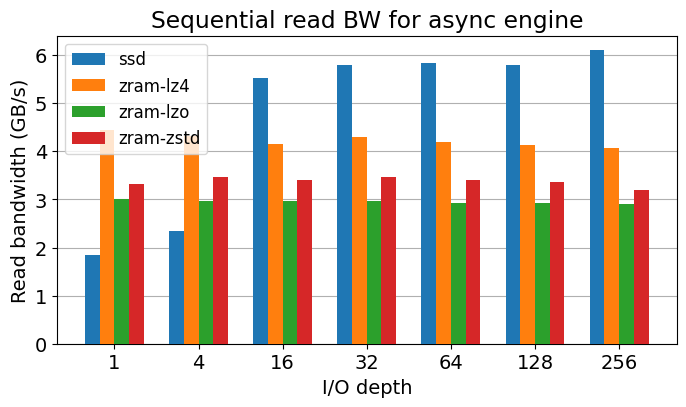

In [26]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT ciodepth FROM df2 ORDER BY ciodepth"), 
    sqflat("""SELECT readBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df2
              WHERE crw='read'
              ORDER BY cdevice, ciodepth"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df2 ORDER BY cdevice"),
    xlabel="I/O depth",
    ylabel="Read bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O2-seqreadBW.png", bbox_inches="tight")
plt.title("Sequential read BW for async engine")
plt.show()

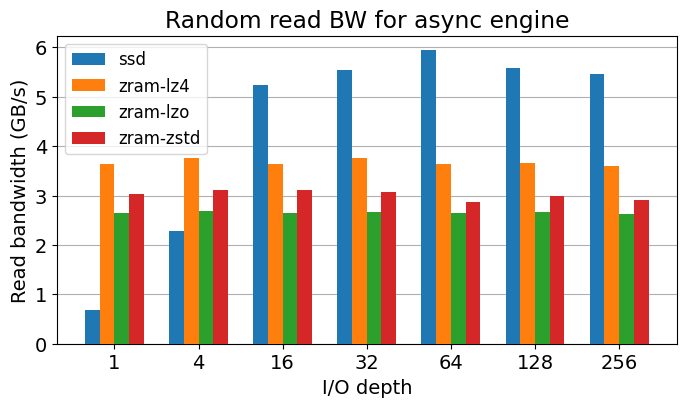

In [27]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT ciodepth FROM df2 ORDER BY ciodepth"), 
    sqflat("""SELECT readBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df2
              WHERE crw='randread'
              ORDER BY cdevice, ciodepth"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df2 ORDER BY cdevice"),
    xlabel="I/O depth",
    ylabel="Read bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O2-randreadBW.png", bbox_inches="tight")
plt.title("Random read BW for async engine")
plt.show()

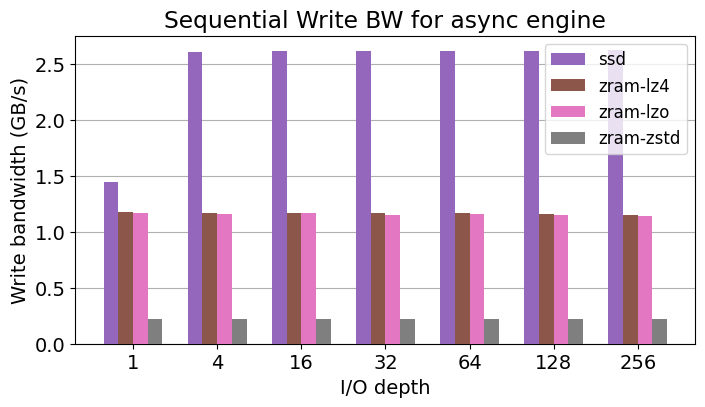

In [28]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT ciodepth FROM df2 ORDER BY ciodepth"), 
    sqflat("""SELECT writeBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB
              from df2_write_redo
              WHERE crw='write'
              ORDER BY cdevice, ciodepth""") \
    + \
    sqflat("""SELECT writeBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df2
              WHERE crw='write' AND (cdevice='zram-lzo' OR cdevice='zram-zstd' OR cdevice='zram-lz4')
              ORDER BY cdevice, ciodepth"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df2 ORDER BY cdevice"),
    colors=["#9467bd", "#8c564b", '#e377c2', '#7f7f7f'],
    xlabel="I/O depth",
    ylabel="Write bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O2-seqwriteBW.png", bbox_inches="tight")
plt.title("Sequential Write BW for async engine")
plt.show()

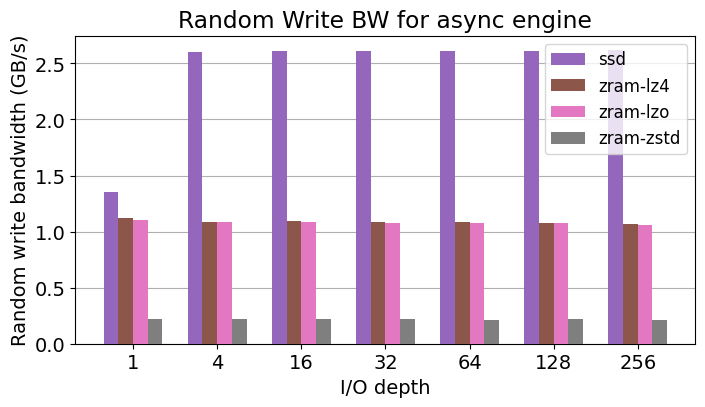

In [29]:
alib.grouped_barplot_flat(
   sqflat("SELECT DISTINCT ciodepth FROM df2 ORDER BY ciodepth"), 
   sqflat("""SELECT writeBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB
              from df2_write_redo
              WHERE crw='randwrite'
              ORDER BY cdevice, ciodepth""") \
    + \
    sqflat("""SELECT writeBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df2
              WHERE crw='randwrite' AND (cdevice='zram-lzo' OR cdevice='zram-zstd' OR cdevice='zram-lz4')
              ORDER BY cdevice, ciodepth"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df2 ORDER BY cdevice"),
    colors=["#9467bd", "#8c564b", '#e377c2', '#7f7f7f'],
    xlabel="I/O depth",
    ylabel="Random write bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O2-randwriteBW.png", bbox_inches="tight")
plt.title("Random Write BW for async engine")
plt.show()

# Interlude: sequential and random gap

Sequential vs Random Bandwidth Ratios (I/O depth = 1)
Devices: ['ssd', 'zram-lz4', 'zram-lzo', 'zram-zstd']
ssd:
  Read:  Sequential=1.85 GB/s, Random=0.68 GB/s, Ratio=2.72x
  Write: Sequential=1.44 GB/s, Random=1.36 GB/s, Ratio=1.06x

zram-lz4:
  Read:  Sequential=4.43 GB/s, Random=3.63 GB/s, Ratio=1.22x
  Write: Sequential=1.18 GB/s, Random=1.12 GB/s, Ratio=1.05x

zram-lzo:
  Read:  Sequential=3.00 GB/s, Random=2.65 GB/s, Ratio=1.13x
  Write: Sequential=1.17 GB/s, Random=1.11 GB/s, Ratio=1.06x

zram-zstd:
  Read:  Sequential=3.32 GB/s, Random=3.03 GB/s, Ratio=1.10x
  Write: Sequential=0.22 GB/s, Random=0.22 GB/s, Ratio=1.02x



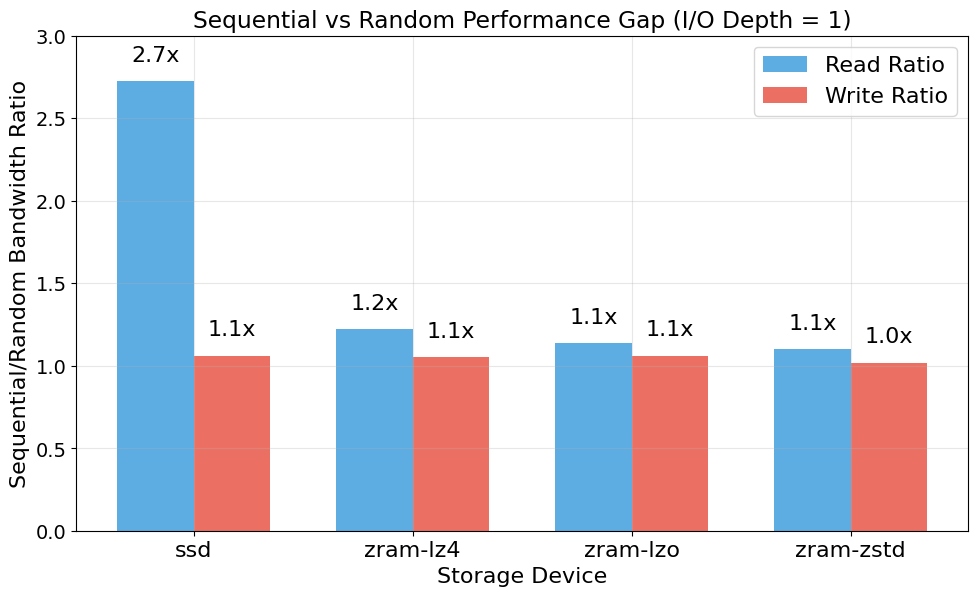

In [78]:
# Sequential vs Random bandwidth ratio analysis at I/O depth = 1
print("Sequential vs Random Bandwidth Ratios (I/O depth = 1)")
print("=" * 60)

# Get devices list
devices = sqflat("SELECT DISTINCT cdevice FROM df2 ORDER BY cdevice")
print(f"Devices: {devices}")

# Get sequential read bandwidth (iodepth=1)
seq_read_bw = sq("""SELECT cdevice, readBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
                    FROM df2 
                    WHERE crw='read' AND ciodepth=1 
                    ORDER BY cdevice""")

# Get random read bandwidth (iodepth=1)
rand_read_bw = sq("""SELECT cdevice, readBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
                     FROM df2 
                     WHERE crw='randread' AND ciodepth=1 
                     ORDER BY cdevice""")

# Get sequential write bandwidth (iodepth=1) - combining both datasets
seq_write_ssd = sq("""SELECT cdevice, writeBW_bytes/(1024.0*1024.0*1024.0) AS writeBW_GB 
                      FROM df2_write_redo 
                      WHERE crw='write' AND ciodepth=1 
                      ORDER BY cdevice""")

seq_write_zram = sq("""SELECT cdevice, writeBW_bytes/(1024.0*1024.0*1024.0) AS writeBW_GB 
                       FROM df2 
                       WHERE crw='write' AND ciodepth=1 AND (cdevice='zram-lzo' OR cdevice='zram-zstd' OR cdevice='zram-lz4')
                       ORDER BY cdevice""")

# Get random write bandwidth (iodepth=1) - combining both datasets
rand_write_ssd = sq("""SELECT cdevice, writeBW_bytes/(1024.0*1024.0*1024.0) AS writeBW_GB 
                       FROM df2_write_redo 
                       WHERE crw='randwrite' AND ciodepth=1 
                       ORDER BY cdevice""")

rand_write_zram = sq("""SELECT cdevice, writeBW_bytes/(1024.0*1024.0*1024.0) AS writeBW_GB 
                        FROM df2 
                        WHERE crw='randwrite' AND ciodepth=1 AND (cdevice='zram-lzo' OR cdevice='zram-zstd' OR cdevice='zram-lz4')
                        ORDER BY cdevice""")

# Combine write data
seq_write_bw = pd.concat([seq_write_ssd, seq_write_zram]).sort_values('cdevice').reset_index(drop=True)
rand_write_bw = pd.concat([rand_write_ssd, rand_write_zram]).sort_values('cdevice').reset_index(drop=True)

# Calculate ratios
read_ratios = []
write_ratios = []
device_labels = []

for i, device in enumerate(devices):
    seq_r = seq_read_bw.iloc[i]['readBW_GB']
    rand_r = rand_read_bw.iloc[i]['readBW_GB']
    seq_w = seq_write_bw.iloc[i]['writeBW_GB']
    rand_w = rand_write_bw.iloc[i]['writeBW_GB']
    
    read_ratio = seq_r / rand_r if rand_r > 0 else 0
    write_ratio = seq_w / rand_w if rand_w > 0 else 0
    
    read_ratios.append(read_ratio)
    write_ratios.append(write_ratio)
    device_labels.append(device)
    
    print(f"{device}:")
    print(f"  Read:  Sequential={seq_r:.2f} GB/s, Random={rand_r:.2f} GB/s, Ratio={read_ratio:.2f}x")
    print(f"  Write: Sequential={seq_w:.2f} GB/s, Random={rand_w:.2f} GB/s, Ratio={write_ratio:.2f}x")
    print()

# Create clustered bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(device_labels))
width = 0.35

bars1 = ax.bar(x - width/2, read_ratios, width, label='Read Ratio', color='#3498db', alpha=0.8)
bars2 = ax.bar(x + width/2, write_ratios, width, label='Write Ratio', color='#e74c3c', alpha=0.8)

# Add value labels on bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.1,
            f'{read_ratios[i]:.1f}x', ha='center', va='bottom', fontsize=16)
    ax.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.1,
            f'{write_ratios[i]:.1f}x', ha='center', va='bottom', fontsize=16)

ax.set_xlabel('Storage Device', fontsize=16)
ax.set_ylabel('Sequential/Random Bandwidth Ratio', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(device_labels, fontsize=16)
ax.legend(fontsize=16)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 3])

plt.tight_layout()
plt.savefig("../../processed-data/2025-10-06-final-run/A-O2-seq-vs-random-ratio.png", bbox_inches="tight")
ax.set_title('Sequential vs Random Performance Gap (I/O Depth = 1)')
plt.show()

# O3 - block size scaling

In [30]:
df3 = pd.read_csv("../../data-raven3/2025-10-06-time-16-45-51-block-sizes-scaling/master.csv")

In [31]:
df3['cbSize'] = df3['cbSize'].apply(alib.unformat_size_1)

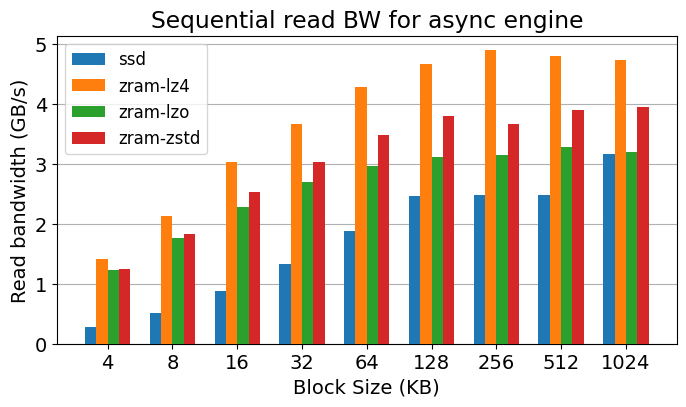

In [32]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT CAST(cbSize/1024 AS int) FROM df3 ORDER BY cbSize"), 
    sqflat("""SELECT readBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df3
              WHERE crw='read'
              ORDER BY cdevice, cbSize"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df3 ORDER BY cdevice"),
    xlabel="Block Size (KB)",
    ylabel="Read bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O3-seqreadBW.png", bbox_inches="tight")
plt.title("Sequential read BW for async engine")
plt.show()

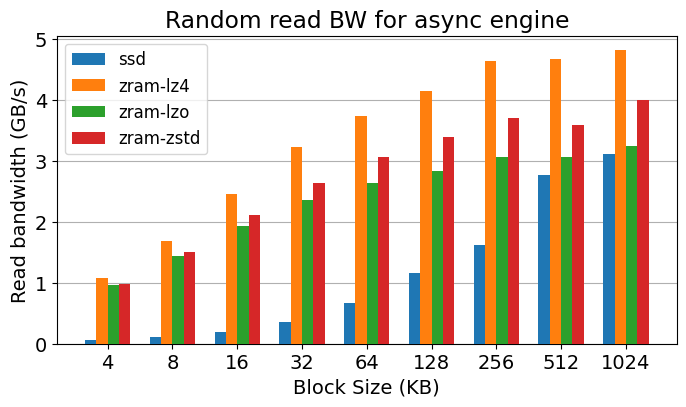

In [33]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT CAST(cbSize/1024 AS int) FROM df3 ORDER BY cbSize"), 
    sqflat("""SELECT readBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df3
              WHERE crw='randread'
              ORDER BY cdevice, cbSize"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df3 ORDER BY cdevice"),
    xlabel="Block Size (KB)",
    ylabel="Read bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O3-randreadBW.png", bbox_inches="tight")
plt.title("Random read BW for async engine")
plt.show()

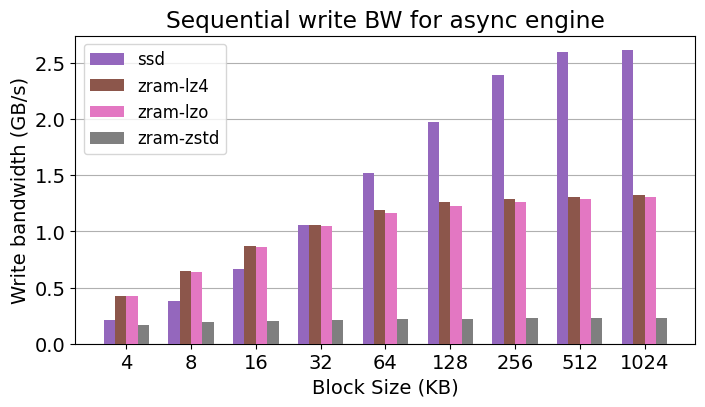

In [34]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT CAST(cbSize/1024 AS int) FROM df3 ORDER BY cbSize"), 
    sqflat("""SELECT writeBW_bytes/(1024.0*1024.0*1024.0) AS writeBW_GB 
              FROM df3
              WHERE crw='write'
              ORDER BY cdevice, cbSize"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df3 ORDER BY cdevice"),
    colors=["#9467bd", "#8c564b", '#e377c2', '#7f7f7f'],
    xlabel="Block Size (KB)",
    ylabel="Write bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O3-seqwriteBW.png", bbox_inches="tight")
plt.title("Sequential write BW for async engine")
plt.show()

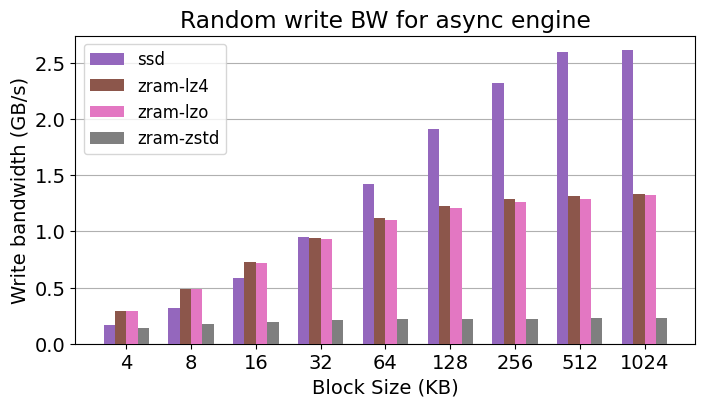

In [35]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT CAST(cbSize/1024 AS int) FROM df3 ORDER BY cbSize"), 
    sqflat("""SELECT writeBW_bytes/(1024.0*1024.0*1024.0) AS writeBW_GB 
              FROM df3
              WHERE crw='randwrite'
              ORDER BY cdevice, cbSize"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df3 ORDER BY cdevice"),
    colors=["#9467bd", "#8c564b", '#e377c2', '#7f7f7f'],
    xlabel="Block Size (KB)",
    ylabel="Write bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O3-randwriteBW.png", bbox_inches="tight")
plt.title("Random write BW for async engine")
plt.show()

In [36]:
sq("""SELECT cdevice, cbSize, writeBW_bytes/(1024.0*1024.0*1024.0) AS writeBW_GB 
      FROM df3
      WHERE crw='randwrite' AND cdevice='zram-zstd'
      ORDER BY cdevice, cbSize
   """), 

(     cdevice     cbSize  writeBW_GB
 0  zram-zstd     4096.0    0.136059
 1  zram-zstd     8192.0    0.171094
 2  zram-zstd    16384.0    0.194690
 3  zram-zstd    32768.0    0.209421
 4  zram-zstd    65536.0    0.217776
 5  zram-zstd   131072.0    0.222154
 6  zram-zstd   262144.0    0.223967
 7  zram-zstd   524288.0    0.225635
 8  zram-zstd  1048576.0    0.226761,)

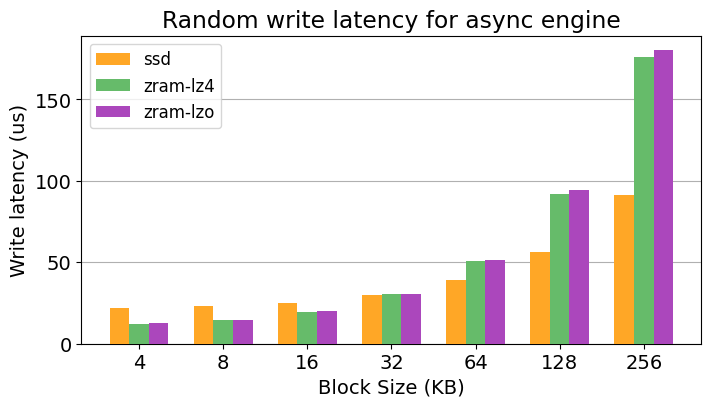

In [37]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT CAST(cbSize/1024 AS int) FROM df3 WHERE cbSize<=1000*500 ORDER BY cbSize"), 
    sqflat("""SELECT avgwritelat_ns/1000.0 AS avgwritelat_us
              FROM df3
              WHERE crw='randwrite' AND NOT cdevice='zram-zstd' AND cbSize<=1000*500
              ORDER BY cdevice, cbSize"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df3 ORDER BY cdevice"),
    colors=["#ffa726", "#66bb6a", "#ab47bc", "#42a5f5"],
    xlabel="Block Size (KB)",
    ylabel="Write latency (us)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O3-randwritelat.png", bbox_inches="tight")
plt.title("Random write latency for async engine")
plt.show()

# O4 - Process scaling

In [38]:
df4_raven3 = pd.read_csv("../../data-raven3/2025-10-06-time-19-27-34-process-scaling/master.csv")
df4_finch2 = pd.read_csv("../../data/2025-10-07-time-22-05-21-process-scaling/master.csv")
df4_raven4 = pd.read_csv("../../data-raven4/2025-10-07-time-22-17-12-process-scaling/master.csv")

In [39]:
df4_raven3.head()

,Unnamed: 0,cbSize,cioengine,ciodepth,crw,cnproc,cdevice,cdirect,cmemlim,cfile,...,diskutil-TOTAL_WRITES(KB),diskutil-TOTAL_READS(MB),diskutil-TOTAL_WRITES(MB),diskutil-TOTAL_READS(GB),diskutil-TOTAL_WRITES(GB),diskutil-rMB/s,diskutil-wMB/s,diskutil-AVGRQ-SZ,diskutil-AVGQU-SZ,diskutil-DEV_UTIL
0,0,64K,sync,1,randread,1,ssd,1,none,none,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,64K,sync,1,randread,1,zram-lzo,1,none,none,...,33558956.0,32768.0,32772.0,32.0,32.0,641.243,655.661,15.64640,0.677800,59.8020
2,2,64K,sync,1,randread,1,zram-zstd,1,none,none,...,33559204.0,32768.0,32772.0,32.0,32.0,229.103,246.496,4.89105,1.126770,86.0759
3,3,64K,sync,1,randread,1,zram-lz4,1,none,none,...,33558956.0,32768.0,32772.0,32.0,32.0,681.446,682.780,12.21440,0.628333,55.7808
4,4,64K,sync,1,randread,16,ssd,1,none,none,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df4_raven3.columns

Index(['Unnamed: 0', 'cbSize', 'cioengine', 'ciodepth', 'crw', 'cnproc',
       'cdevice', 'cdirect', 'cmemlim', 'cfile', 'cbuffer_compress_percentage',
       'cbuffer_compress_chunk', 'readBW_bytes', 'readBW', 'writeBW_bytes',
       'writeBW', 'avgreadlat_ns', 'avgreadlat', 'avgwritelat_ns',
       'avgwritelat', 'USR_UTIL_perc', 'SYS_UTIL_perc', 'IOW_UTIL_perc',
       'IDL_UTIL_perc', 'CPU_UTIL_perc', 'diskutil-TOTAL_READS(KB)',
       'diskutil-TOTAL_WRITES(KB)', 'diskutil-TOTAL_READS(MB)',
       'diskutil-TOTAL_WRITES(MB)', 'diskutil-TOTAL_READS(GB)',
       'diskutil-TOTAL_WRITES(GB)', 'diskutil-rMB/s', 'diskutil-wMB/s',
       'diskutil-AVGRQ-SZ', 'diskutil-AVGQU-SZ', 'diskutil-DEV_UTIL'],
      dtype='object')

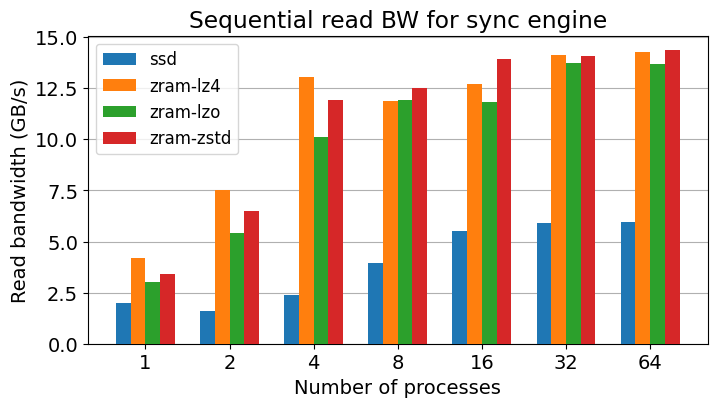

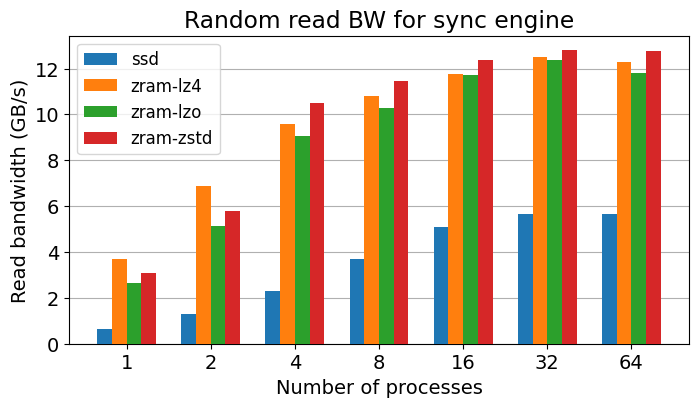

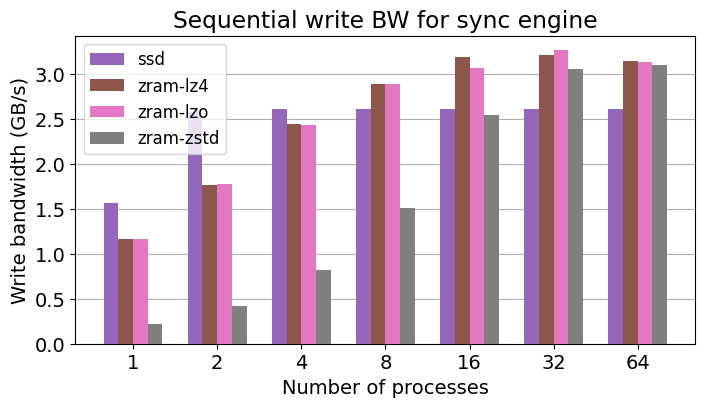

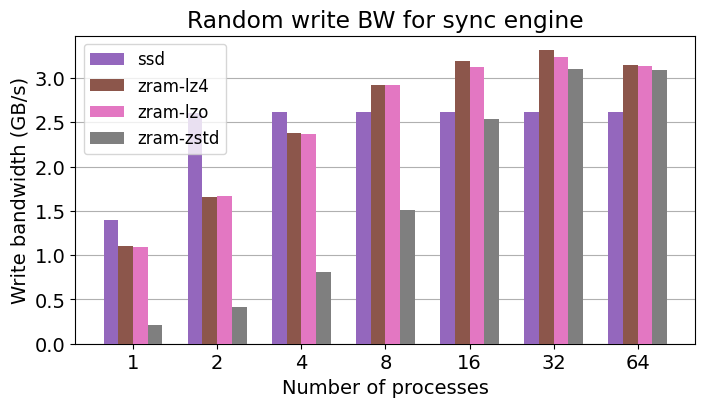

In [41]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM df4_raven3 ORDER BY cnproc"), 
    sqflat("""SELECT readBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df4_raven3
              WHERE crw='read'
              ORDER BY cdevice, cnproc"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df4_raven3 ORDER BY cdevice"),
    xlabel="Number of processes",
    ylabel="Read bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O4-raven3-seqreadBW.png", bbox_inches="tight")
plt.title("Sequential read BW for sync engine")
plt.show()

alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM df4_raven3 ORDER BY cnproc"), 
    sqflat("""SELECT readBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df4_raven3
              WHERE crw='randread'
              ORDER BY cdevice, cnproc"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df4_raven3 ORDER BY cdevice"),
    xlabel="Number of processes",
    ylabel="Read bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O4-raven3-randreadBW.png", bbox_inches="tight")
plt.title("Random read BW for sync engine")
plt.show()

alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM df4_raven3 ORDER BY cnproc"), 
    sqflat("""SELECT writeBW_bytes/(1024.0*1024.0*1024.0) AS writeBW_GB 
              FROM df4_raven3
              WHERE crw='write'
              ORDER BY cdevice, cnproc"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df4_raven3 ORDER BY cdevice"),
    colors=["#9467bd", "#8c564b", '#e377c2', '#7f7f7f'],
    xlabel="Number of processes",
    ylabel="Write bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O4-raven3-seqwriteBW.png", bbox_inches="tight")
plt.title("Sequential write BW for sync engine")
plt.show()

alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM df4_raven3 ORDER BY cnproc"), 
    sqflat("""SELECT writeBW_bytes/(1024.0*1024.0*1024.0) AS writeBW_GB 
              FROM df4_raven3
              WHERE crw='randwrite'
              ORDER BY cdevice, cnproc"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df4_raven3 ORDER BY cdevice"),
    colors=["#9467bd", "#8c564b", '#e377c2', '#7f7f7f'],
    xlabel="Number of processes",
    ylabel="Write bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O4-raven3-randwriteBW.png", bbox_inches="tight")
plt.title("Random write BW for sync engine")
plt.show()

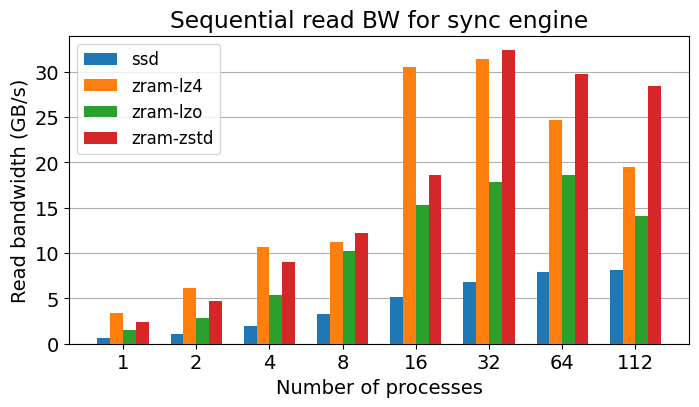

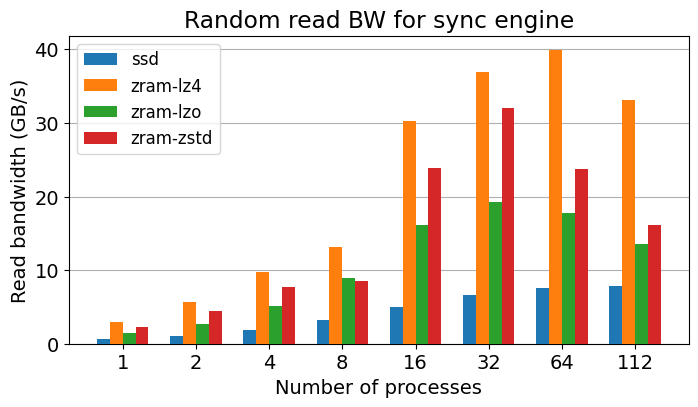

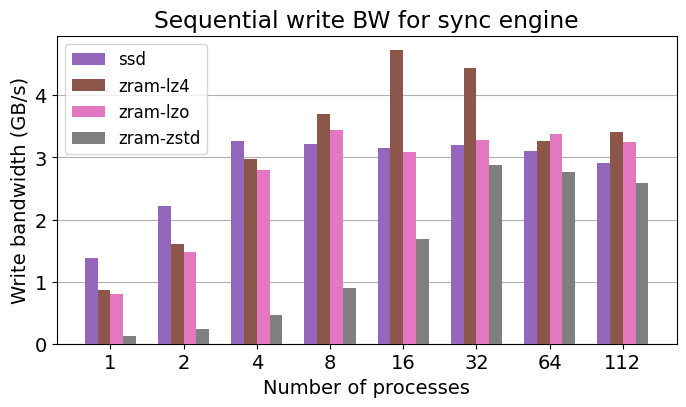

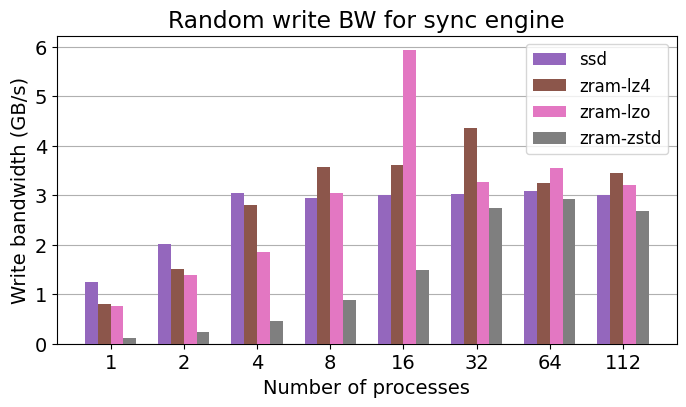

In [42]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM df4_finch2 ORDER BY cnproc"), 
    sqflat("""SELECT readBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df4_finch2
              WHERE crw='read'
              ORDER BY cdevice, cnproc"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df4_finch2 ORDER BY cdevice"),
    xlabel="Number of processes",
    ylabel="Read bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O4-finch2-seqreadBW.png", bbox_inches="tight")
plt.title("Sequential read BW for sync engine")
plt.show()

alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM df4_finch2 ORDER BY cnproc"), 
    sqflat("""SELECT readBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df4_finch2
              WHERE crw='randread'
              ORDER BY cdevice, cnproc"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df4_finch2 ORDER BY cdevice"),
    xlabel="Number of processes",
    ylabel="Read bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O4-finch2-randreadBW.png", bbox_inches="tight")
plt.title("Random read BW for sync engine")
plt.show()

alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM df4_finch2 ORDER BY cnproc"), 
    sqflat("""SELECT writeBW_bytes/(1024.0*1024.0*1024.0) AS writeBW_GB 
              FROM df4_finch2
              WHERE crw='write'
              ORDER BY cdevice, cnproc"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df4_finch2 ORDER BY cdevice"),
    colors=["#9467bd", "#8c564b", '#e377c2', '#7f7f7f'],
    xlabel="Number of processes",
    ylabel="Write bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O4-finch2-seqwriteBW.png", bbox_inches="tight")
plt.title("Sequential write BW for sync engine")
plt.show()

alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM df4_finch2 ORDER BY cnproc"), 
    sqflat("""SELECT writeBW_bytes/(1024.0*1024.0*1024.0) AS writeBW_GB 
              FROM df4_finch2
              WHERE crw='randwrite'
              ORDER BY cdevice, cnproc"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df4_finch2 ORDER BY cdevice"),
    colors=["#9467bd", "#8c564b", '#e377c2', '#7f7f7f'],
    xlabel="Number of processes",
    ylabel="Write bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O4-finch2-randwriteBW.png", bbox_inches="tight")
plt.title("Random write BW for sync engine")
plt.show()

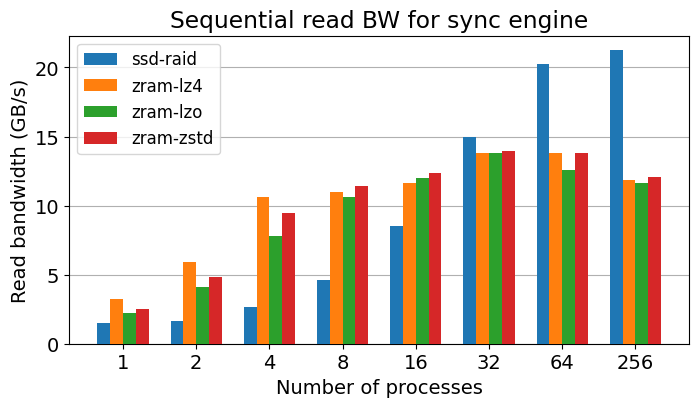

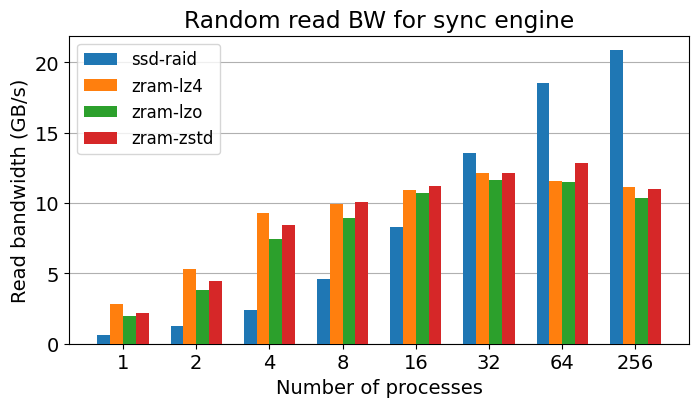

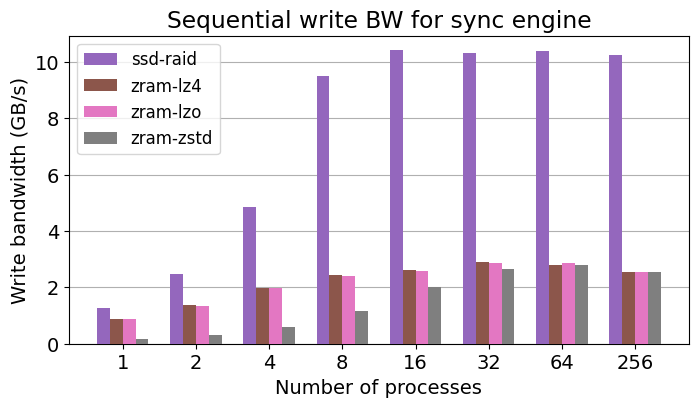

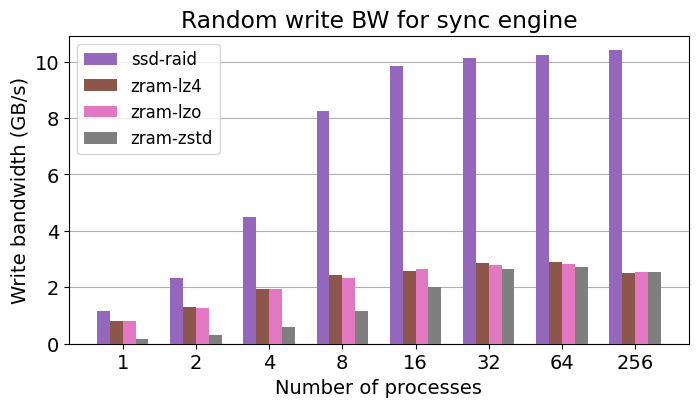

In [43]:
alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM df4_raven4 ORDER BY cnproc"), 
    sqflat("""SELECT readBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df4_raven4
              WHERE crw='read'
              ORDER BY cdevice, cnproc"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df4_raven4 ORDER BY cdevice"),
    xlabel="Number of processes",
    ylabel="Read bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O4-raven4-seqreadBW.png", bbox_inches="tight")
plt.title("Sequential read BW for sync engine")
plt.show()

alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM df4_raven4 ORDER BY cnproc"), 
    sqflat("""SELECT readBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df4_raven4
              WHERE crw='randread'
              ORDER BY cdevice, cnproc"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df4_raven4 ORDER BY cdevice"),
    xlabel="Number of processes",
    ylabel="Read bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O4-raven4-randreadBW.png", bbox_inches="tight")
plt.title("Random read BW for sync engine")
plt.show()

alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM df4_raven4 ORDER BY cnproc"), 
    sqflat("""SELECT writeBW_bytes/(1024.0*1024.0*1024.0) AS writeBW_GB 
              FROM df4_raven4
              WHERE crw='write'
              ORDER BY cdevice, cnproc"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df4_raven4 ORDER BY cdevice"),
    colors=["#9467bd", "#8c564b", '#e377c2', '#7f7f7f'],
    xlabel="Number of processes",
    ylabel="Write bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O4-raven4-seqwriteBW.png", bbox_inches="tight")
plt.title("Sequential write BW for sync engine")
plt.show()

alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM df4_raven4 ORDER BY cnproc"), 
    sqflat("""SELECT writeBW_bytes/(1024.0*1024.0*1024.0) AS writeBW_GB 
              FROM df4_raven4
              WHERE crw='randwrite'
              ORDER BY cdevice, cnproc"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df4_raven4 ORDER BY cdevice"),
    colors=["#9467bd", "#8c564b", '#e377c2', '#7f7f7f'],
    xlabel="Number of processes",
    ylabel="Write bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O4-raven4-randwriteBW.png", bbox_inches="tight")
plt.title("Random write BW for sync engine")
plt.show()

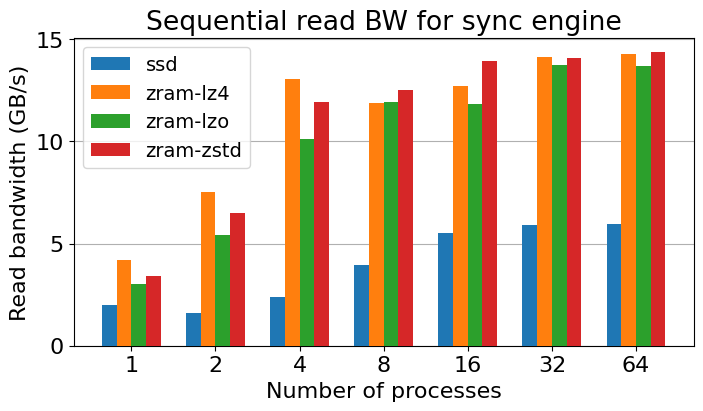

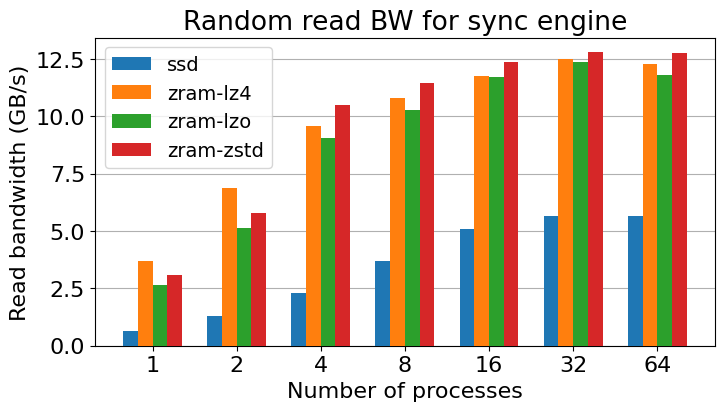

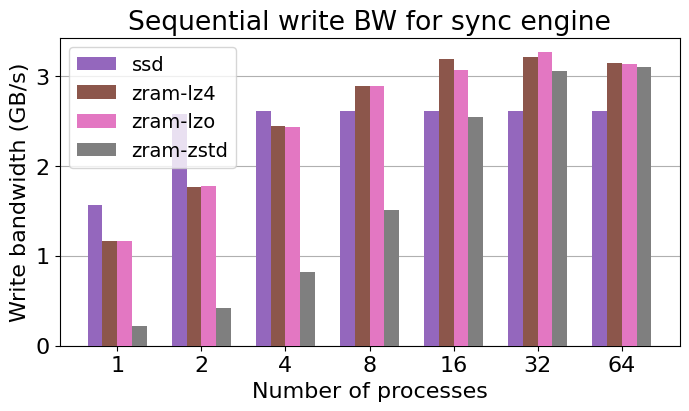

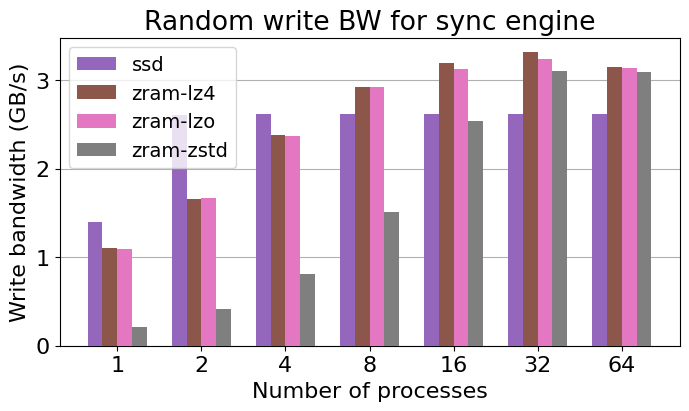

In [44]:
# just for poster
plt.rcParams.update({'font.size': 16, 'legend.fontsize': 14})

alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM df4_raven3 ORDER BY cnproc"), 
    sqflat("""SELECT readBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df4_raven3
              WHERE crw='read'
              ORDER BY cdevice, cnproc"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df4_raven3 ORDER BY cdevice"),
    xlabel="Number of processes",
    ylabel="Read bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O4-poster-raven3-seqreadBW.png", bbox_inches="tight")
plt.title("Sequential read BW for sync engine")
plt.show()

alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM df4_raven3 ORDER BY cnproc"), 
    sqflat("""SELECT readBW_bytes/(1024.0*1024.0*1024.0) AS readBW_GB 
              FROM df4_raven3
              WHERE crw='randread'
              ORDER BY cdevice, cnproc"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df4_raven3 ORDER BY cdevice"),
    xlabel="Number of processes",
    ylabel="Read bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O4-poster-raven3-randreadBW.png", bbox_inches="tight")
plt.title("Random read BW for sync engine")
plt.show()

alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM df4_raven3 ORDER BY cnproc"), 
    sqflat("""SELECT writeBW_bytes/(1024.0*1024.0*1024.0) AS writeBW_GB 
              FROM df4_raven3
              WHERE crw='write'
              ORDER BY cdevice, cnproc"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df4_raven3 ORDER BY cdevice"),
    colors=["#9467bd", "#8c564b", '#e377c2', '#7f7f7f'],
    xlabel="Number of processes",
    ylabel="Write bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O4-poster-raven3-seqwriteBW.png", bbox_inches="tight")
plt.title("Sequential write BW for sync engine")
plt.show()

alib.grouped_barplot_flat(
    sqflat("SELECT DISTINCT cnproc FROM df4_raven3 ORDER BY cnproc"), 
    sqflat("""SELECT writeBW_bytes/(1024.0*1024.0*1024.0) AS writeBW_GB 
              FROM df4_raven3
              WHERE crw='randwrite'
              ORDER BY cdevice, cnproc"""), 
    labels=sqflat("SELECT DISTINCT cdevice FROM df4_raven3 ORDER BY cdevice"),
    colors=["#9467bd", "#8c564b", '#e377c2', '#7f7f7f'],
    xlabel="Number of processes",
    ylabel="Write bandwidth (GB/s)",
    show=False
)
plt.savefig("../../processed-data/2025-10-06-final-run/A-O4-poster-raven3-randwriteBW.png", bbox_inches="tight")
plt.title("Random write BW for sync engine")
plt.show()

plt.rcParams.update({'font.size': 14, 'legend.fontsize': 12})

In [67]:
sq("""SELECT crw, readBW_bytes/(1024.0*1024*1024) AS readBW_GB, writeBW_bytes/(1024.0*1024*1024) AS writeBW_GB
      FROM df4_finch2
      WHERE cdevice='ssd' and cnproc=1""")

,crw,readBW_GB,writeBW_GB
0,randread,0.574207,0.000000
1,randwrite,0.000000,1.246494
2,read,0.589123,0.000000
3,write,0.000000,1.383485


In [71]:
sq("""SELECT crw, readBW_bytes/(1024.0*1024*1024) AS readBW_GB, writeBW_bytes/(1024.0*1024*1024) AS writeBW_GB
      FROM df4_raven3
      WHERE cdevice='ssd' and cnproc=64""")

,crw,readBW_GB,writeBW_GB
0,randread,5.654709,0.000000
1,randwrite,0.000000,2.612885
2,read,5.965697,0.000000
3,write,0.000000,2.614593


In [65]:
sq("""SELECT crw, readBW_bytes/(1024.0*1024*1024) AS readBW_GB, writeBW_bytes/(1024.0*1024*1024) AS writeBW_GB
      FROM df4_raven4
      WHERE cdevice='ssd-raid' and cnproc=256""")

,crw,readBW_GB,writeBW_GB
0,randread,20.860495,0.000000
1,randwrite,0.000000,10.396361
2,read,21.234240,0.000000
3,write,0.000000,10.230179
